# Predicting Customer Responses to Term Deposit Campaigns: A Banking Case Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

# Loading Data

In [3]:
bank_marketing_data = pd.read_csv("bank-full.csv", delimiter=";")
bank_marketing_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [5]:
# Rename target 'y' as 'subscribed'
bank_marketing_data.rename(columns={'y': 'subscribed'}, inplace=True)

# Perform an initial split to explore the data
eda_train_df, eda_test_df = train_test_split(
    bank_marketing_data, train_size=0.60, stratify=bank_marketing_data["subscribed"], random_state=509
)
eda_train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
30025,35,blue-collar,divorced,primary,no,21,yes,no,cellular,4,feb,166,2,-1,0,unknown,no
22889,35,technician,married,secondary,no,31,no,no,cellular,25,aug,390,8,-1,0,unknown,no
22666,59,blue-collar,married,primary,no,6271,yes,no,cellular,25,aug,102,5,-1,0,unknown,no
31826,25,admin.,single,secondary,no,654,no,no,cellular,8,apr,216,1,-1,0,unknown,no
19420,59,admin.,married,unknown,no,64343,no,no,cellular,6,aug,45,4,-1,0,unknown,no


## Exploratory Data Analysis (EDA)

In [8]:
eda_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27126 entries, 30025 to 40348
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         27126 non-null  int64 
 1   job         27126 non-null  object
 2   marital     27126 non-null  object
 3   education   27126 non-null  object
 4   default     27126 non-null  object
 5   balance     27126 non-null  int64 
 6   housing     27126 non-null  object
 7   loan        27126 non-null  object
 8   contact     27126 non-null  object
 9   day         27126 non-null  int64 
 10  month       27126 non-null  object
 11  duration    27126 non-null  int64 
 12  campaign    27126 non-null  int64 
 13  pdays       27126 non-null  int64 
 14  previous    27126 non-null  int64 
 15  poutcome    27126 non-null  object
 16  subscribed  27126 non-null  object
dtypes: int64(7), object(10)
memory usage: 3.7+ MB


In [10]:
bank_marketing_summary = eda_train_df.describe(include = 'all')
bank_marketing_summary

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
count,27126.000000,27126,27126,27126,27126,27126.000000,27126,27126,27126,27126.000000,27126,27126.000000,27126.000000,27126.000000,27126.000000,27126,27126
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,5843,16313,13854,26647,NaN,15042,22784,17552,NaN,8312,NaN,NaN,NaN,NaN,22211,23953
mean,40.926823,NaN,NaN,NaN,NaN,1359.845720,NaN,NaN,NaN,15.822569,NaN,258.761557,2.772248,39.628733,0.573509,NaN,NaN
std,10.634093,NaN,NaN,NaN,NaN,3008.755885,NaN,NaN,NaN,8.310742,NaN,261.410827,3.087187,99.140830,2.507419,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,71.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,443.500000,NaN,NaN,NaN,16.000000,NaN,179.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1437.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [12]:
# Check for NAs (manually check)
eda_train_df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

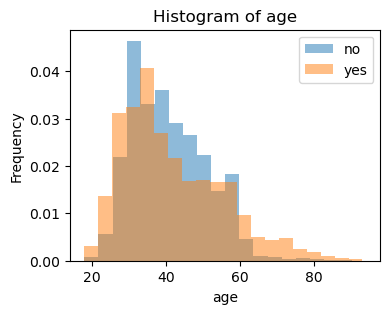

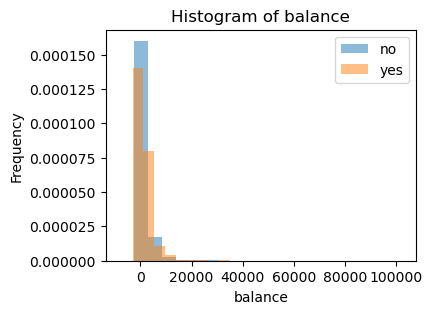

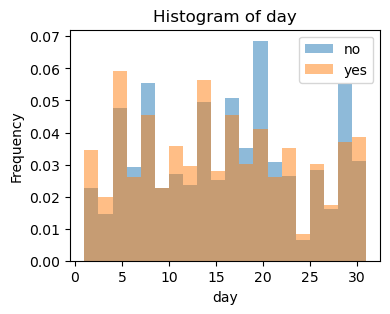

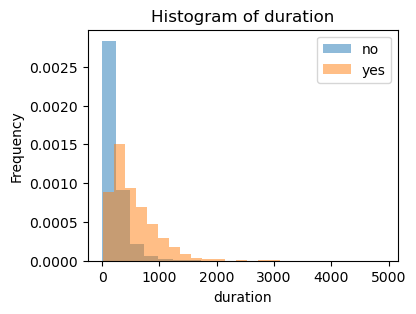

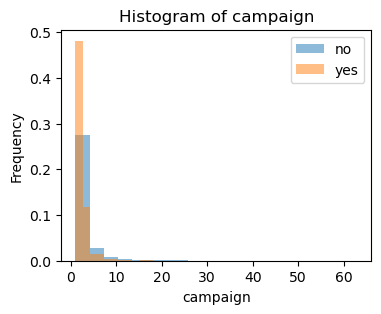

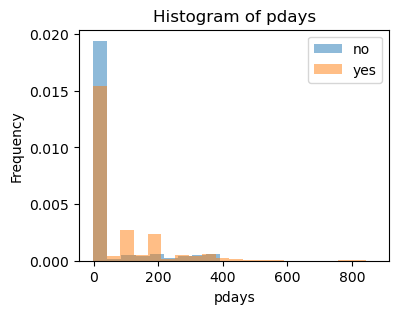

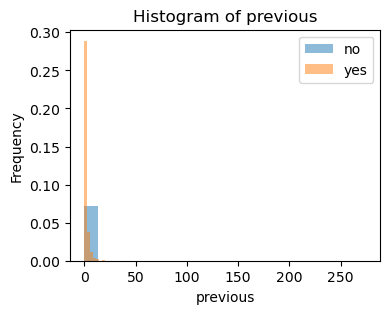

In [14]:
# Plot distribution of numerical columns grouped by 'subscribed'
numeric_columns = eda_train_df.select_dtypes(include=['number']).columns.to_list()

for column in numeric_columns:
    plt.figure(figsize=(4, 3))
    eda_train_df.groupby("subscribed")[column].plot.hist(
        bins=20, 
        alpha=0.5, 
        legend=True, 
        density=True, 
        title=f"Histogram of {column}"
    )
    plt.xlabel(column)
    plt.show()

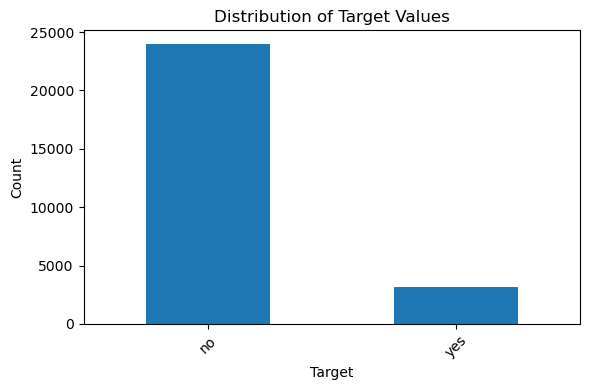

In [16]:
# Visualize the imbalance in the target class
target_counts = eda_train_df["subscribed"].value_counts()

plt.figure(figsize=(6, 4))
target_counts.plot(kind="bar")
plt.title("Distribution of Target Values")
plt.xlabel("Target")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Display distinct values in categorical columns
categorical_columns = ["job", "marital", "education"]

for col in categorical_columns:
    unique_values = eda_train_df[col].unique()
    print(f"{col}: {list(unique_values)}")

job: ['blue-collar', 'technician', 'admin.', 'retired', 'services', 'management', 'unknown', 'unemployed', 'self-employed', 'housemaid', 'student', 'entrepreneur']
marital: ['divorced', 'married', 'single']
education: ['primary', 'secondary', 'unknown', 'tertiary']


# Preprocessing

In [21]:
# Remove poutcome and contact columns because they provide little predictive value.
# Remove duration due to data leakage (it is only known 
# after the call is made and directly influences the target variable).
bank_marketing_data = bank_marketing_data.drop(["poutcome", "contact","duration"], axis = 1)
bank_marketing_data = bank_marketing_data.dropna()
bank_marketing_data

,age,job,marital,education,default,balance,housing,loan,day,month,campaign,pdays,previous,subscribed
0,58,management,married,tertiary,no,2143,yes,no,5,may,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,5,may,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1,-1,0,no
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,1,-1,0,no
4,33,unknown,single,unknown,no,1,no,no,5,may,1,-1,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,17,nov,3,-1,0,yes
45207,71,retired,divorced,primary,no,1729,no,no,17,nov,2,-1,0,yes
45208,72,retired,married,secondary,no,5715,no,no,17,nov,5,184,3,yes
45209,57,blue-collar,married,secondary,no,668,no,no,17,nov,4,-1,0,no


In [23]:
# Preprocess data (such as scale and split into train & test)
np.random.seed(509)
set_config(transform_output="pandas")

# Create the split
bank_marketing_train, bank_marketing_test = train_test_split(
    bank_marketing_data, train_size=0.60, stratify=bank_marketing_data["subscribed"]
)

In [25]:
numeric_features = ['age', 'balance', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital']
ordinal_features = ['education']
binary_features = ['default', 'housing', 'loan']
drop_features = ['day', 'month']
target = "subscribed"

In [27]:
X_train = bank_marketing_train.drop(columns=target)
y_train = bank_marketing_train[target]
X_test = bank_marketing_test.drop(columns=target)
y_test = bank_marketing_test[target]

In [29]:
# Define data preprocessing transformers
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

education_order = ['primary', 'secondary', 'tertiary']
ordinal_transformer = OrdinalEncoder(
    categories=[education_order],
    dtype=int,
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

binary_transformer = OneHotEncoder(
    drop="if_binary", 
    dtype=int, 
    handle_unknown="ignore", 
    sparse_output=False
)

In [31]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),  
    (categorical_transformer, categorical_features),
    ("drop", drop_features),  
)

preprocessor.fit(X_train)
preprocessed_X_train = preprocessor.transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

preprocessed_X_train

,standardscaler__age,standardscaler__balance,standardscaler__campaign,standardscaler__pdays,standardscaler__previous,ordinalencoder__education,onehotencoder-1__default_yes,onehotencoder-1__housing_yes,onehotencoder-1__loan_yes,onehotencoder-2__job_admin.,...,onehotencoder-2__job_retired,onehotencoder-2__job_self-employed,onehotencoder-2__job_services,onehotencoder-2__job_student,onehotencoder-2__job_technician,onehotencoder-2__job_unemployed,onehotencoder-2__job_unknown,onehotencoder-2__marital_divorced,onehotencoder-2__marital_married,onehotencoder-2__marital_single
30025,-0.557352,-0.444991,-0.250151,-0.409816,-0.228729,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22889,-0.557352,-0.441668,1.693402,-0.409816,-0.228729,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
22666,1.699582,1.632317,0.721625,-0.409816,-0.228729,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31826,-1.497741,-0.234602,-0.574076,-0.409816,-0.228729,1,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19420,1.699582,20.933674,0.397700,-0.409816,-0.228729,-1,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39622,-0.651391,-0.451971,-0.574076,-0.409816,-0.228729,2,0,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
37196,-1.215624,-0.257867,-0.574076,3.332405,0.568919,1,0,1,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40447,-1.403702,0.497608,-0.574076,-0.409816,-0.228729,2,0,0,0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32548,-0.651391,-0.218315,-0.250151,1.113298,0.568919,1,0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Model training

We conducted hyperparameter optimization for three classification models: k-nearest neighbors classifier, logistic regression, and random forest. To identify the best-performing model, we utilized 5-fold cross-validation within a GridSearch framework, using the F-beta score (beta = 5) as the evaluation metric for prediction performance.

In [35]:
model_comparison = { "model_name": [], "mean_train_score": [], "mean_test_score": [] }

### K-Nearest Neighbors

In [38]:
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier(n_jobs=-1))

# 'n_neighbors': Number of nearest neighbors used for classification. 
#                Controls decision boundary smoothness.
parameter_grid = {
    "kneighborsclassifier__n_neighbors": np.arange(1, 10, 2),
}

cv = 5
knn_search = GridSearchCV(
    estimator=knn_pipe,
    param_grid=parameter_grid,
    cv=cv,
    scoring=make_scorer(fbeta_score, pos_label='yes', beta=5),
    n_jobs=-1,
    return_train_score=True,
)

bank_marketing_fit_knn = knn_search.fit(X_train, y_train)

In [39]:
# Extract best model scores for K-Nearest Neighbors
best_model_scores_knn = pd.DataFrame(knn_search.cv_results_)[ [
                 "mean_test_score",
                 "mean_train_score",
                 "param_kneighborsclassifier__n_neighbors",
                 "rank_test_score",
] ].set_index("rank_test_score").sort_index().iloc[1, :]

# Add K-Nearest Neighbors results to model comparison
model_comparison["model_name"].append("K-Nearest Neighbors")
model_comparison["mean_train_score"].append(best_model_scores_knn["mean_train_score"])
model_comparison["mean_test_score"].append(best_model_scores_knn["mean_test_score"])

In [40]:
accuracies_grid_knn = pd.DataFrame(bank_marketing_fit_knn.cv_results_)
accuracies_grid_knn = (
    accuracies_grid_knn[["param_kneighborsclassifier__n_neighbors", "mean_test_score"]]
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "k"})
)

accuracies_grid_knn.sort_values("mean_test_score", ascending=False)

,k,mean_test_score
0,1,0.237060
1,3,0.167814
2,5,0.139713
3,7,0.119295
4,9,0.107152


### Logistic Regression

In [45]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=500, class_weight={'no': 1, 'yes': 10}))

# 'C': Inverse of regularization strength. 
#      Higher values reduce regularization, making the model more flexible.
parameter_grid = {
    "logisticregression__C": 10.0 ** np.arange(-3, 5, 1),
}

cv = 5
lr_search = GridSearchCV(
    estimator=lr_pipe,
    param_grid=parameter_grid,
    cv=cv,
    scoring=make_scorer(fbeta_score, pos_label='yes', beta=5),
    n_jobs=-1,
    return_train_score=True,
)

bank_marketing_fit_lr = lr_search.fit(X_train, y_train)

In [46]:
# Extract best model scores for Logistic Regression
best_model_scores_lr = pd.DataFrame(lr_search.cv_results_)[ [
                 "mean_test_score",
                 "mean_train_score",
                 "param_logisticregression__C",
                 "rank_test_score",
] ].set_index("rank_test_score").sort_index().iloc[1, :]

# Add Logistic Regression results to model comparison
model_comparison["model_name"].append("Logistic Regression")
model_comparison["mean_train_score"].append(best_model_scores_lr["mean_train_score"])
model_comparison["mean_test_score"].append(best_model_scores_lr["mean_test_score"])

In [47]:
accuracies_grid_lr = pd.DataFrame(bank_marketing_fit_lr.cv_results_)
accuracies_grid_lr = (
    accuracies_grid_lr[["param_logisticregression__C", "mean_test_score"]]
    .rename(columns={"param_logisticregression__C": "C"})
)

accuracies_grid_lr.sort_values("mean_test_score", ascending=False)


,C,mean_test_score
0,0.001,0.685559
1,0.010,0.667665
2,0.100,0.663711
5,100.000,0.663631
6,1000.000,0.663631
7,10000.000,0.663631
4,10.000,0.663624
3,1.000,0.663603


### Random Forest

In [52]:
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, class_weight={'no': 1, 'yes': 10}))

# 'n_estimators': Number of trees in the forest. 
#                 Higher values may improve performance but increase computation time.
# 'max_depth': Maximum depth of each tree. Limits model complexity to prevent overfitting.
parameter_grid = {
    "randomforestclassifier__n_estimators": [100, 200, 300, 400, 500],
    "randomforestclassifier__max_depth": [3, 5, 7, 15, None],
}

cv = 5
rf_search = GridSearchCV(
    estimator=rf_pipe,
    param_grid=parameter_grid,
    cv=cv,
    scoring=make_scorer(fbeta_score, pos_label='yes', beta=5),
    n_jobs=-1,
    return_train_score=True,
)

bank_marketing_fit_rf = rf_search.fit(X_train, y_train)

In [53]:
# Extract best model scores for Random Forest
best_model_scores_rf = pd.DataFrame(rf_search.cv_results_)[ [
                 "mean_test_score",
                 "mean_train_score",
                 "param_randomforestclassifier__n_estimators",
                 "param_randomforestclassifier__max_depth",
                 "rank_test_score",
] ].set_index("rank_test_score").sort_index().iloc[1, :]

# Add Random Forest results to model comparison
model_comparison["model_name"].append("Random Forest")
model_comparison["mean_train_score"].append(best_model_scores_rf["mean_train_score"])
model_comparison["mean_test_score"].append(best_model_scores_rf["mean_test_score"])

In [54]:
accuracies_grid_rf = pd.DataFrame(bank_marketing_fit_rf.cv_results_)
accuracies_grid_rf = (
    accuracies_grid_rf[[
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_test_score"
    ]]
    .rename(columns={
        "param_randomforestclassifier__n_estimators": "n_estimators",
        "param_randomforestclassifier__max_depth": "max_depth"
    })
)

accuracies_grid_rf.sort_values("mean_test_score", ascending=False)

,n_estimators,max_depth,mean_test_score
1,200,3,0.698719
3,400,3,0.698312
2,300,3,0.696878
0,100,3,0.696834
4,500,3,0.695902
9,500,5,0.666480
8,400,5,0.665039
6,200,5,0.664916
5,100,5,0.664842
7,300,5,0.663147


# Model comparison

In [56]:
pd.DataFrame(model_comparison)

,model_name,mean_train_score,mean_test_score
0,K-Nearest Neighbors,0.369618,0.167814
1,Logistic Regression,0.673535,0.667665
2,Random Forest,0.700969,0.698312


# Prediction

In [58]:
# Compute accuracy
y_pred = bank_marketing_fit_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Compute F-beta score (beta = 5)
bank_marketing_preds = X_test.assign(
    predicted=bank_marketing_fit_rf.predict(X_test)
)
f_beta_5_score = fbeta_score(
    y_test,
    bank_marketing_preds['predicted'],
    beta=5,
    pos_label='yes'
)

# Predict probabilities for ROC curve
y_probs = bank_marketing_fit_rf.predict_proba(X_test)[:, 1]  # Probabilities for class 'yes'

# Compute confusion matrix
y_pred = bank_marketing_fit_rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute AUC-ROC score
auc_roc = roc_auc_score(y_test, y_probs)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_probs, pos_label='yes')
auc_pr = auc(recall, precision)

# Print evaluation scores
pd.DataFrame({
    'Accuracy': [accuracy],
    'F-beta Score (beta=5)': [f_beta_5_score],
    'AUC-ROC Score': [auc_roc],
    'AUC-PR Score': [auc_pr]
})

,Accuracy,F-beta Score (beta=5),AUC-ROC Score,AUC-PR Score
0,0.482002,0.701686,0.718587,0.300254


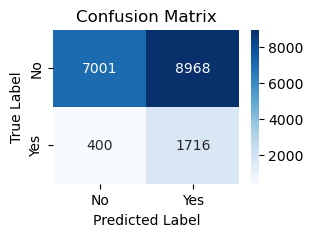

In [59]:
# Plot confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

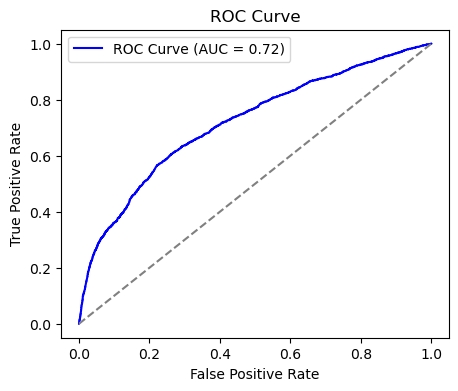

In [60]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs, pos_label='yes')
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

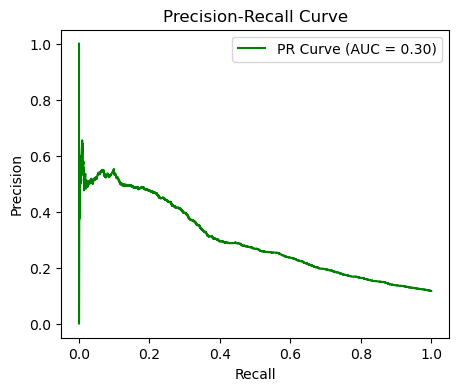

In [68]:
# Plot PR-ROC curve
plt.figure(figsize=(5, 4))
plt.plot(recall, precision, color='green', label=f'PR Curve (AUC = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# feature importance

In [71]:
best_rf_model = bank_marketing_fit_rf.best_estimator_.named_steps["randomforestclassifier"]

feature_names = preprocessor.get_feature_names_out()

feature_importances = best_rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

                               Feature  Importance
3                standardscaler__pdays    0.220950
7         onehotencoder-1__housing_yes    0.194689
4             standardscaler__previous    0.177979
1              standardscaler__balance    0.100272
0                  standardscaler__age    0.095899
2             standardscaler__campaign    0.049490
8            onehotencoder-1__loan_yes    0.032066
10    onehotencoder-2__job_blue-collar    0.029297
14        onehotencoder-2__job_retired    0.026021
23     onehotencoder-2__marital_single    0.017991
5            ordinalencoder__education    0.017660
22    onehotencoder-2__marital_married    0.016357
17        onehotencoder-2__job_student    0.013264
13     onehotencoder-2__job_management    0.001725
11   onehotencoder-2__job_entrepreneur    0.001318
6         onehotencoder-1__default_yes    0.001253
15  onehotencoder-2__job_self-employed    0.000671
19     onehotencoder-2__job_unemployed    0.000638
16       onehotencoder-2__job_s

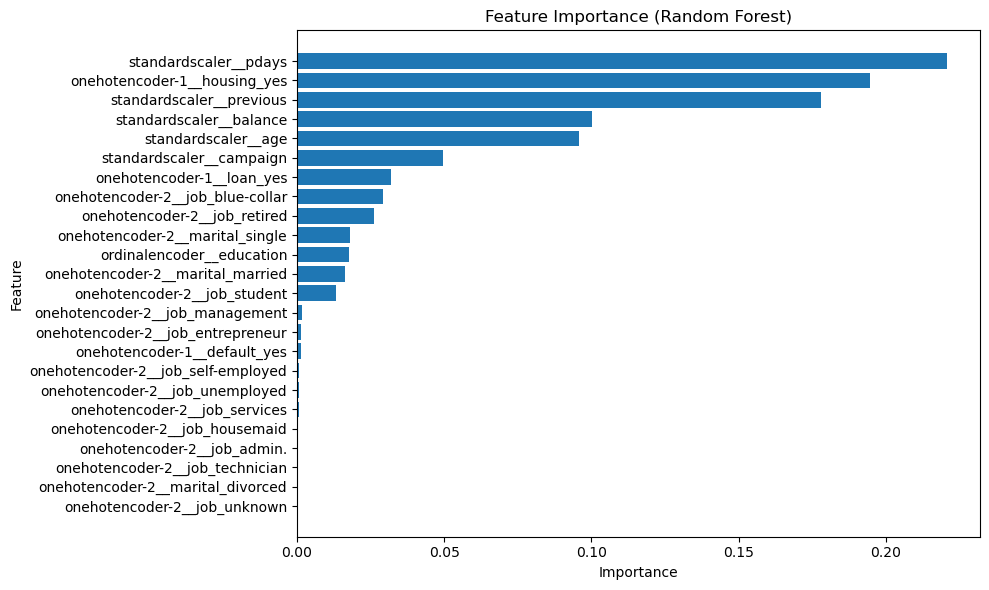

In [73]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [75]:
from sklearn.inspection import permutation_importance

# Extract the trained Random Forest model
best_rf_model = bank_marketing_fit_rf.best_estimator_.named_steps["randomforestclassifier"]

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# Transform validation/test data
X_val_transformed = preprocessor.transform(X_train)  # Use validation or test data
y_val = y_train  # Ensure y_val is defined

# Compute permutation importance
perm_importance = permutation_importance(
    best_rf_model, X_val_transformed, y_val, n_repeats=10, random_state=42, scoring="accuracy"
)

# Create DataFrame for feature importance
perm_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean  # Mean importance score
}).sort_values(by="Importance", ascending=False)

print(perm_importance_df)

                               Feature  Importance
3                standardscaler__pdays    0.047641
4             standardscaler__previous    0.046715
7         onehotencoder-1__housing_yes    0.013371
0                  standardscaler__age    0.009836
1              standardscaler__balance    0.008398
2             standardscaler__campaign    0.004099
14        onehotencoder-2__job_retired    0.002205
23     onehotencoder-2__marital_single    0.001445
17        onehotencoder-2__job_student    0.001427
8            onehotencoder-1__loan_yes    0.000877
22    onehotencoder-2__marital_married    0.000391
11   onehotencoder-2__job_entrepreneur    0.000195
21   onehotencoder-2__marital_divorced    0.000118
6         onehotencoder-1__default_yes    0.000111
19     onehotencoder-2__job_unemployed    0.000070
20        onehotencoder-2__job_unknown    0.000029
15  onehotencoder-2__job_self-employed   -0.000044
12      onehotencoder-2__job_housemaid   -0.000048
18     onehotencoder-2__job_tec

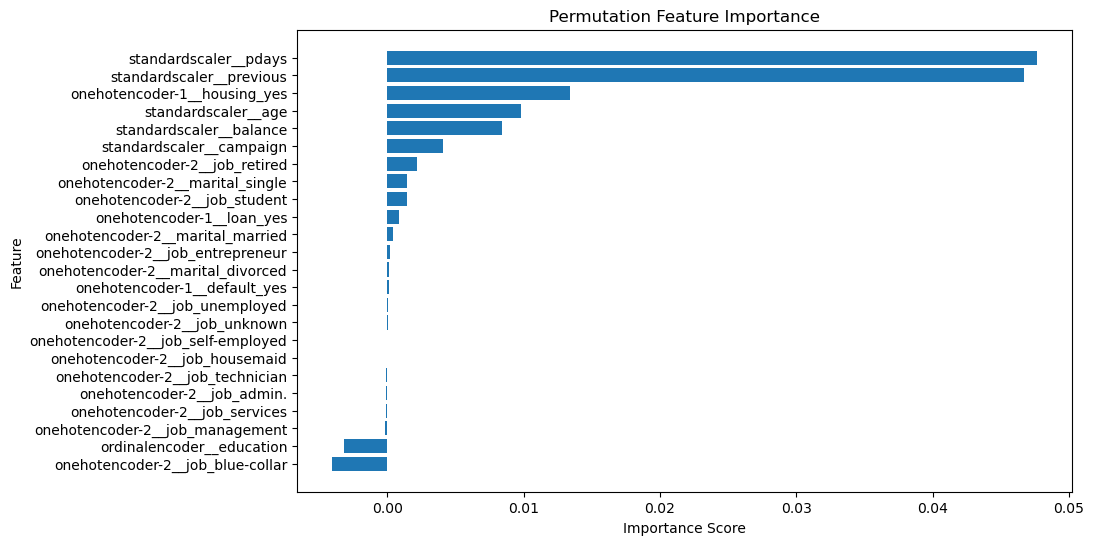

In [77]:
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df["Feature"], perm_importance_df["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.show()